In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from cluster_util.spark_util import SparkUtil
from cluster_util.hive_util import HiveUtil

In [45]:
spark = SparkUtil().build_spark_session(app_name="Shared Bike Analysis System notebook")

2021-11-22 21:59:01,865	File "spark_util.py", line 25	INFO: Build spark session ...
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/11/22 21:59:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [47]:
spark.sql('show databases').show()

+----------+
| namespace|
+----------+
|   default|
|sharedbike|
+----------+



In [49]:
spark.sql('use sharedbike')
spark.sql('show tables').show()

+----------+------------+-----------+
| namespace|   tableName|isTemporary|
+----------+------------+-----------+
|sharedbike|trip_details|      false|
+----------+------------+-----------+



In [51]:
ptd="2021"
desc_list_names = ['duration', 'start_lat', 'start_lon', 'end_lat', 'end_lon', 'plan_duration',  'trip_route_type',
                               'passholder_type', 'bike_type', 'distance', 'season', 'holiday', 'workingday']
df_by_year = spark.sql('select {} from trip_details where ptd={};'.format(','.join(desc_list_names), ptd))

In [54]:
df_by_year.toPandas().describe().T

,count,mean,std,min,25%,50%,75%,max
duration,153989.0,41.147673,98.049854,1.000000,9.000000,19.000000,37.000000,1440.000000
start_lat,153989.0,34.029836,0.038370,33.928459,33.996239,34.038609,34.050880,34.186569
start_lon,153989.0,-118.345096,0.096136,-118.491341,-118.451248,-118.291496,-118.258537,-118.225410
end_lat,153989.0,34.029810,0.038001,33.928459,33.998341,34.037460,34.050480,34.186569
end_lon,153989.0,-118.345834,0.096722,-118.491341,-118.451248,-118.291718,-118.258537,-118.225410
plan_duration,153989.0,48.578457,102.870918,1.000000,1.000000,30.000000,30.000000,999.000000
trip_route_type,153989.0,1.243537,0.429218,1.000000,1.000000,1.000000,1.000000,2.000000
passholder_type,153988.0,2.317849,1.024294,1.000000,1.000000,3.000000,3.000000,4.000000
bike_type,153989.0,1.278773,0.471785,1.000000,1.000000,1.000000,2.000000,3.000000
distance,153989.0,29.592958,35.449078,0.000000,4.025301,20.554560,41.013824,517.316467


In [55]:
spark.stop()

In [10]:
trip_data_by_year_df = pd.read_csv('results/trip_details/trip_details.csv')

In [11]:
trip_data_by_year_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153989 entries, 0 to 153988
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   trip_id          153989 non-null  int64  
 1   duration         153989 non-null  int64  
 2   start_station    153989 non-null  int64  
 3   start_lat        153989 non-null  float64
 4   start_lon        153989 non-null  float64
 5   end_station      153989 non-null  int64  
 6   end_lat          153989 non-null  float64
 7   end_lon          153989 non-null  float64
 8   bike_id          153981 non-null  float64
 9   plan_duration    153989 non-null  int64  
 10  trip_route_type  153989 non-null  int64  
 11  passholder_type  153988 non-null  float64
 12  bike_type        153989 non-null  int64  
 13  distance         153989 non-null  float64
 14  distance_cal     153989 non-null  float64
 15  used_date        153989 non-null  object 
 16  season           153989 non-null  int6

In [12]:
trip_data_by_year_df.head(3)

,trip_id,duration,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,...,distance,distance_cal,used_date,season,holiday,workingday,start_datetime,end_datetime,start_hour,ptd
0,156638487,49,3014,34.05661,-118.237213,3030,34.051941,-118.243530,12215.0,1,...,15.192432,0.744,4/1/2021,2,0,1,2021-04-01T04:35:00.000-07:00,2021-04-01T05:24:00.000-07:00,2021-04-01-04,2021
1,156641187,8,4491,34.04744,-118.247940,3014,34.056610,-118.237213,5848.0,365,...,27.305515,1.287,4/1/2021,2,0,1,2021-04-01T05:55:00.000-07:00,2021-04-01T06:03:00.000-07:00,2021-04-01-05,2021
2,156641988,13,4478,34.10424,-118.273697,4401,34.075611,-118.291862,5940.0,1,...,65.718460,2.521,4/1/2021,2,0,1,2021-04-01T06:31:00.000-07:00,2021-04-01T06:44:00.000-07:00,2021-04-01-06,2021


In [15]:
trip_data_by_year_df[['duration', 'start_lat', 'start_lon', 'end_lat', 'end_lon', 'plan_duration',  'trip_route_type',
                               'passholder_type', 'bike_type', 'distance', 'season', 'holiday', 'workingday']].describe().T

,count,mean,std,min,25%,50%,75%,max
duration,153989.0,41.147673,98.049854,1.000000,9.000000,19.000000,37.000000,1440.000000
start_lat,153989.0,34.029836,0.038370,33.928459,33.996239,34.038609,34.050880,34.186569
start_lon,153989.0,-118.345096,0.096136,-118.491341,-118.451248,-118.291496,-118.258537,-118.225410
end_lat,153989.0,34.029810,0.038001,33.928459,33.998341,34.037460,34.050480,34.186569
end_lon,153989.0,-118.345834,0.096722,-118.491341,-118.451248,-118.291718,-118.258537,-118.225410
plan_duration,153989.0,48.578457,102.870918,1.000000,1.000000,30.000000,30.000000,999.000000
trip_route_type,153989.0,1.243537,0.429218,1.000000,1.000000,1.000000,1.000000,2.000000
passholder_type,153988.0,2.317849,1.024294,1.000000,1.000000,3.000000,3.000000,4.000000
bike_type,153989.0,1.278773,0.471785,1.000000,1.000000,1.000000,2.000000,3.000000
distance,153989.0,29.592954,35.449079,0.000000,4.025301,20.554560,41.013824,517.316470


<AxesSubplot:xlabel='workingday', ylabel='count'>

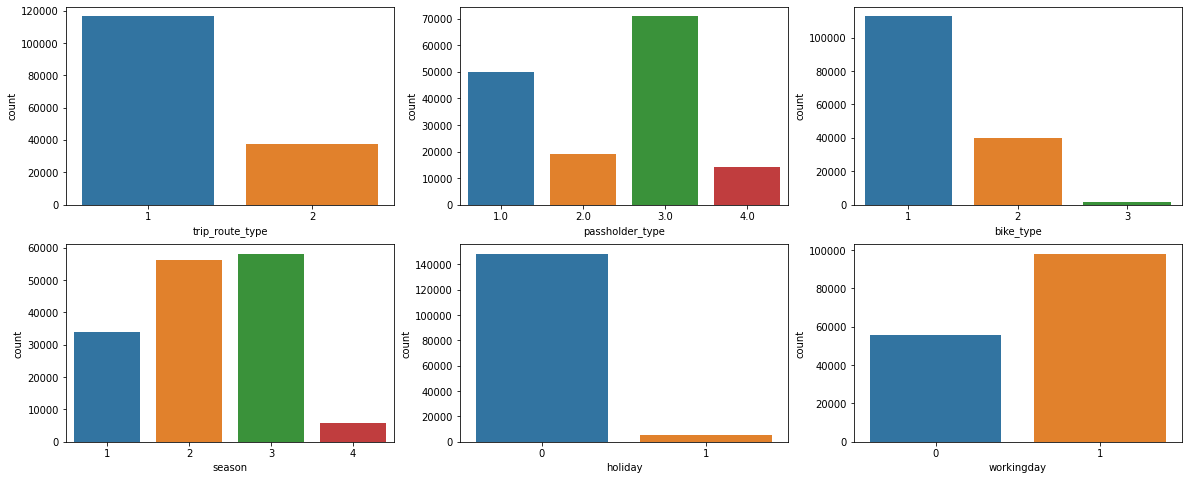

In [16]:
# countplot in categorical variable
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(20, 8)

# col_name = ['trip_route_type', 'passholder_type', 'bike_type', 'season', 'holiday', 'workingday']

sns.countplot(trip_data_by_year_df['trip_route_type'], ax=axes[0][0])
sns.countplot(trip_data_by_year_df['passholder_type'], ax=axes[0][1])
sns.countplot(trip_data_by_year_df['bike_type'], ax=axes[0][2])
sns.countplot(trip_data_by_year_df['season'], ax=axes[1][0])
sns.countplot(trip_data_by_year_df['holiday'], ax=axes[1][1])
sns.countplot(trip_data_by_year_df['workingday'], ax=axes[1][2])

<AxesSubplot:xlabel='season', ylabel='ptd'>

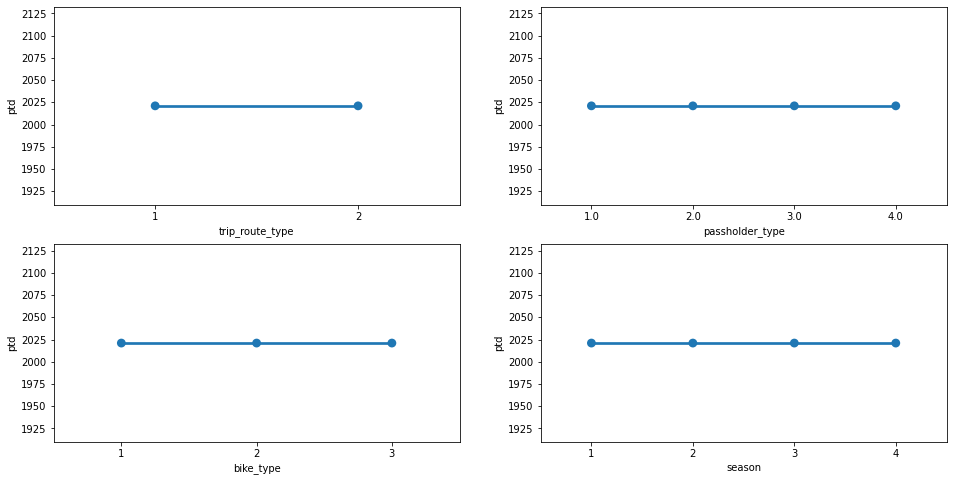

In [17]:
# pointplot in categorical variable
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(16,8)

sns.pointplot(data=trip_data_by_year_df, x='trip_route_type', y='ptd', ax=axes[0][0])
sns.pointplot(data=trip_data_by_year_df, x='passholder_type', y='ptd', ax=axes[0][1])
sns.pointplot(data=trip_data_by_year_df, x='bike_type', y='ptd', ax=axes[1][0])
sns.pointplot(data=trip_data_by_year_df, x='season', y='ptd', ax=axes[1][1])

# sns.pointplot(data=trip_data_by_year, x='trip_route_type', ax=axes[0][0])
# sns.pointplot(data=trip_data_by_year, x='passholder_type', ax=axes[0][1])
# sns.pointplot(data=trip_data_by_year, x='bike_type', ax=axes[0][2])
# sns.pointplot(data=trip_data_by_year, x='season', ax=axes[1][0])
# sns.pointplot(data=trip_data_by_year, x='holiday', ax=axes[1][1])
# sns.pointplot(data=trip_data_by_year, x='workingday', ax=axes[1][2])

In [20]:
# app_trip_cnt_by_hour
app_trip_cnt_by_hour_df = pd.read_csv('results/app/app_trip_cnt_by_hour/part-00000-dd2e4669-3cb2-4879-a832-752f6b98087b-c000.csv')

In [21]:
app_trip_cnt_by_hour_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6046 entries, 0 to 6045
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   start_hour                        6046 non-null   object
 1   used_count                        6046 non-null   int64 
 2   total_duration                    6046 non-null   int64 
 3   plan_duration_day_count           6046 non-null   int64 
 4   plan_duration_month_count         6046 non-null   int64 
 5   plan_duration_year_count          6046 non-null   int64 
 6   trip_route_type_one_way_count     6046 non-null   int64 
 7   trip_route_type_round_trip_count  6046 non-null   int64 
 8   passholder_type_walk_up_count     6046 non-null   int64 
 9   passholder_type_one_day_count     6046 non-null   int64 
 10  passholder_type_monthly_count     6046 non-null   int64 
 11  passholder_type_annual_count      6046 non-null   int64 
 12  bike_type_standard_c

In [22]:
app_trip_cnt_by_hour_df.head(3)

,start_hour,used_count,total_duration,plan_duration_day_count,plan_duration_month_count,plan_duration_year_count,trip_route_type_one_way_count,trip_route_type_round_trip_count,passholder_type_walk_up_count,passholder_type_one_day_count,passholder_type_monthly_count,passholder_type_annual_count,bike_type_standard_count,bike_type_electric_count,bike_type_smart_count,season,holiday,workingday
0,2021-01-01-01,1,17,1,0,0,1,0,1,0,0,0,1,0,0,1,1,0
1,2021-01-01-02,1,7,0,0,1,1,0,0,0,0,1,0,1,0,1,1,0
2,2021-01-01-04,2,216,1,1,0,2,0,1,0,1,0,2,0,0,1,1,0


In [23]:
app_trip_cnt_by_hour_df.describe().T

,count,mean,std,min,25%,50%,75%,max
used_count,6046.0,25.469567,20.707366,1.0,6.00,22.0,40.0,142.0
total_duration,6046.0,1048.013397,1141.688522,1.0,160.25,684.0,1555.0,10524.0
plan_duration_day_count,6046.0,11.339563,11.908931,0.0,2.00,7.0,17.0,79.0
plan_duration_month_count,6046.0,11.736189,9.372877,0.0,3.00,11.0,18.0,112.0
plan_duration_year_count,6046.0,2.393649,2.627686,0.0,0.00,2.0,4.0,19.0
trip_route_type_one_way_count,6046.0,19.266788,15.579677,0.0,5.00,17.0,30.0,130.0
trip_route_type_round_trip_count,6046.0,6.202779,6.332285,0.0,1.00,4.0,10.0,48.0
passholder_type_walk_up_count,6046.0,8.279854,8.759412,0.0,1.00,5.0,12.0,60.0
passholder_type_one_day_count,6046.0,3.134138,4.248490,0.0,0.00,1.5,5.0,35.0
passholder_type_monthly_count,6046.0,11.735528,9.371976,0.0,3.00,11.0,18.0,112.0


<AxesSubplot:xlabel='holiday', ylabel='used_count'>

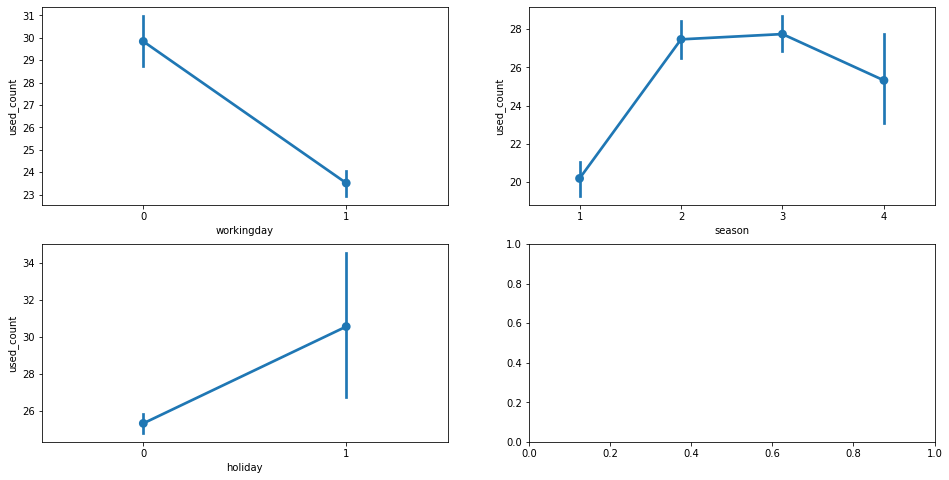

In [25]:
# pointplot in categorical variable
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(16,8)

sns.pointplot(data=app_trip_cnt_by_hour_df, x='workingday', y='used_count', ax=axes[0][0])
sns.pointplot(data=app_trip_cnt_by_hour_df, x='season', y='used_count', ax=axes[0][1])
sns.pointplot(data=app_trip_cnt_by_hour_df, x='holiday', y='used_count', ax=axes[1][0])